In [38]:
import matplotlib.pyplot as plt 
from glob import glob
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization

import tensorflow.keras.utils as np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
#import tensorflow_addons as tfa
from keras.models import Model

from matplotlib.colors import ListedColormap
import matplotlib as mpl
#from keras.utils.training_utils import multi_gpu_model


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os
import math
import pandas as pd

In [2]:
# GPU를 사용하도록 설정
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [40]:
%%time
grids=500
base='/tf/dataset/'
data = np.load(base+str(grids)+'data_noiseX_nside2.npz')

CPU times: user 4.12 ms, sys: 5 µs, total: 4.12 ms
Wall time: 2.95 ms


In [41]:
name_train = data['name_train'].copy()
X_train = data['X_train'].copy()
y_train = data['y_train'].copy().astype(int)
#y_train[y_train==2]=1

name_val = data['name_val'].copy()
X_val = data['X_val'].copy()
y_val = data['y_val'].copy().astype(int)
#y_val[y_val==2]=1

name_test = data['name_test'].copy()
X_test = data['X_test'].copy()
y_test = data['y_test'].copy().astype(int)
#y_test[y_test==2]=1

## Randomize Xtrain and Ytrain

In [42]:
numtrain = X_train.shape[0]
print(numtrain)

2172


In [43]:
import random
randidx = list(range(numtrain))
random.shuffle(randidx)

In [44]:
y_train[randidx]

array([1, 0, 0, ..., 1, 1, 1])

In [45]:
X_train = X_train[randidx]
y_train = y_train[randidx]

## Show Images

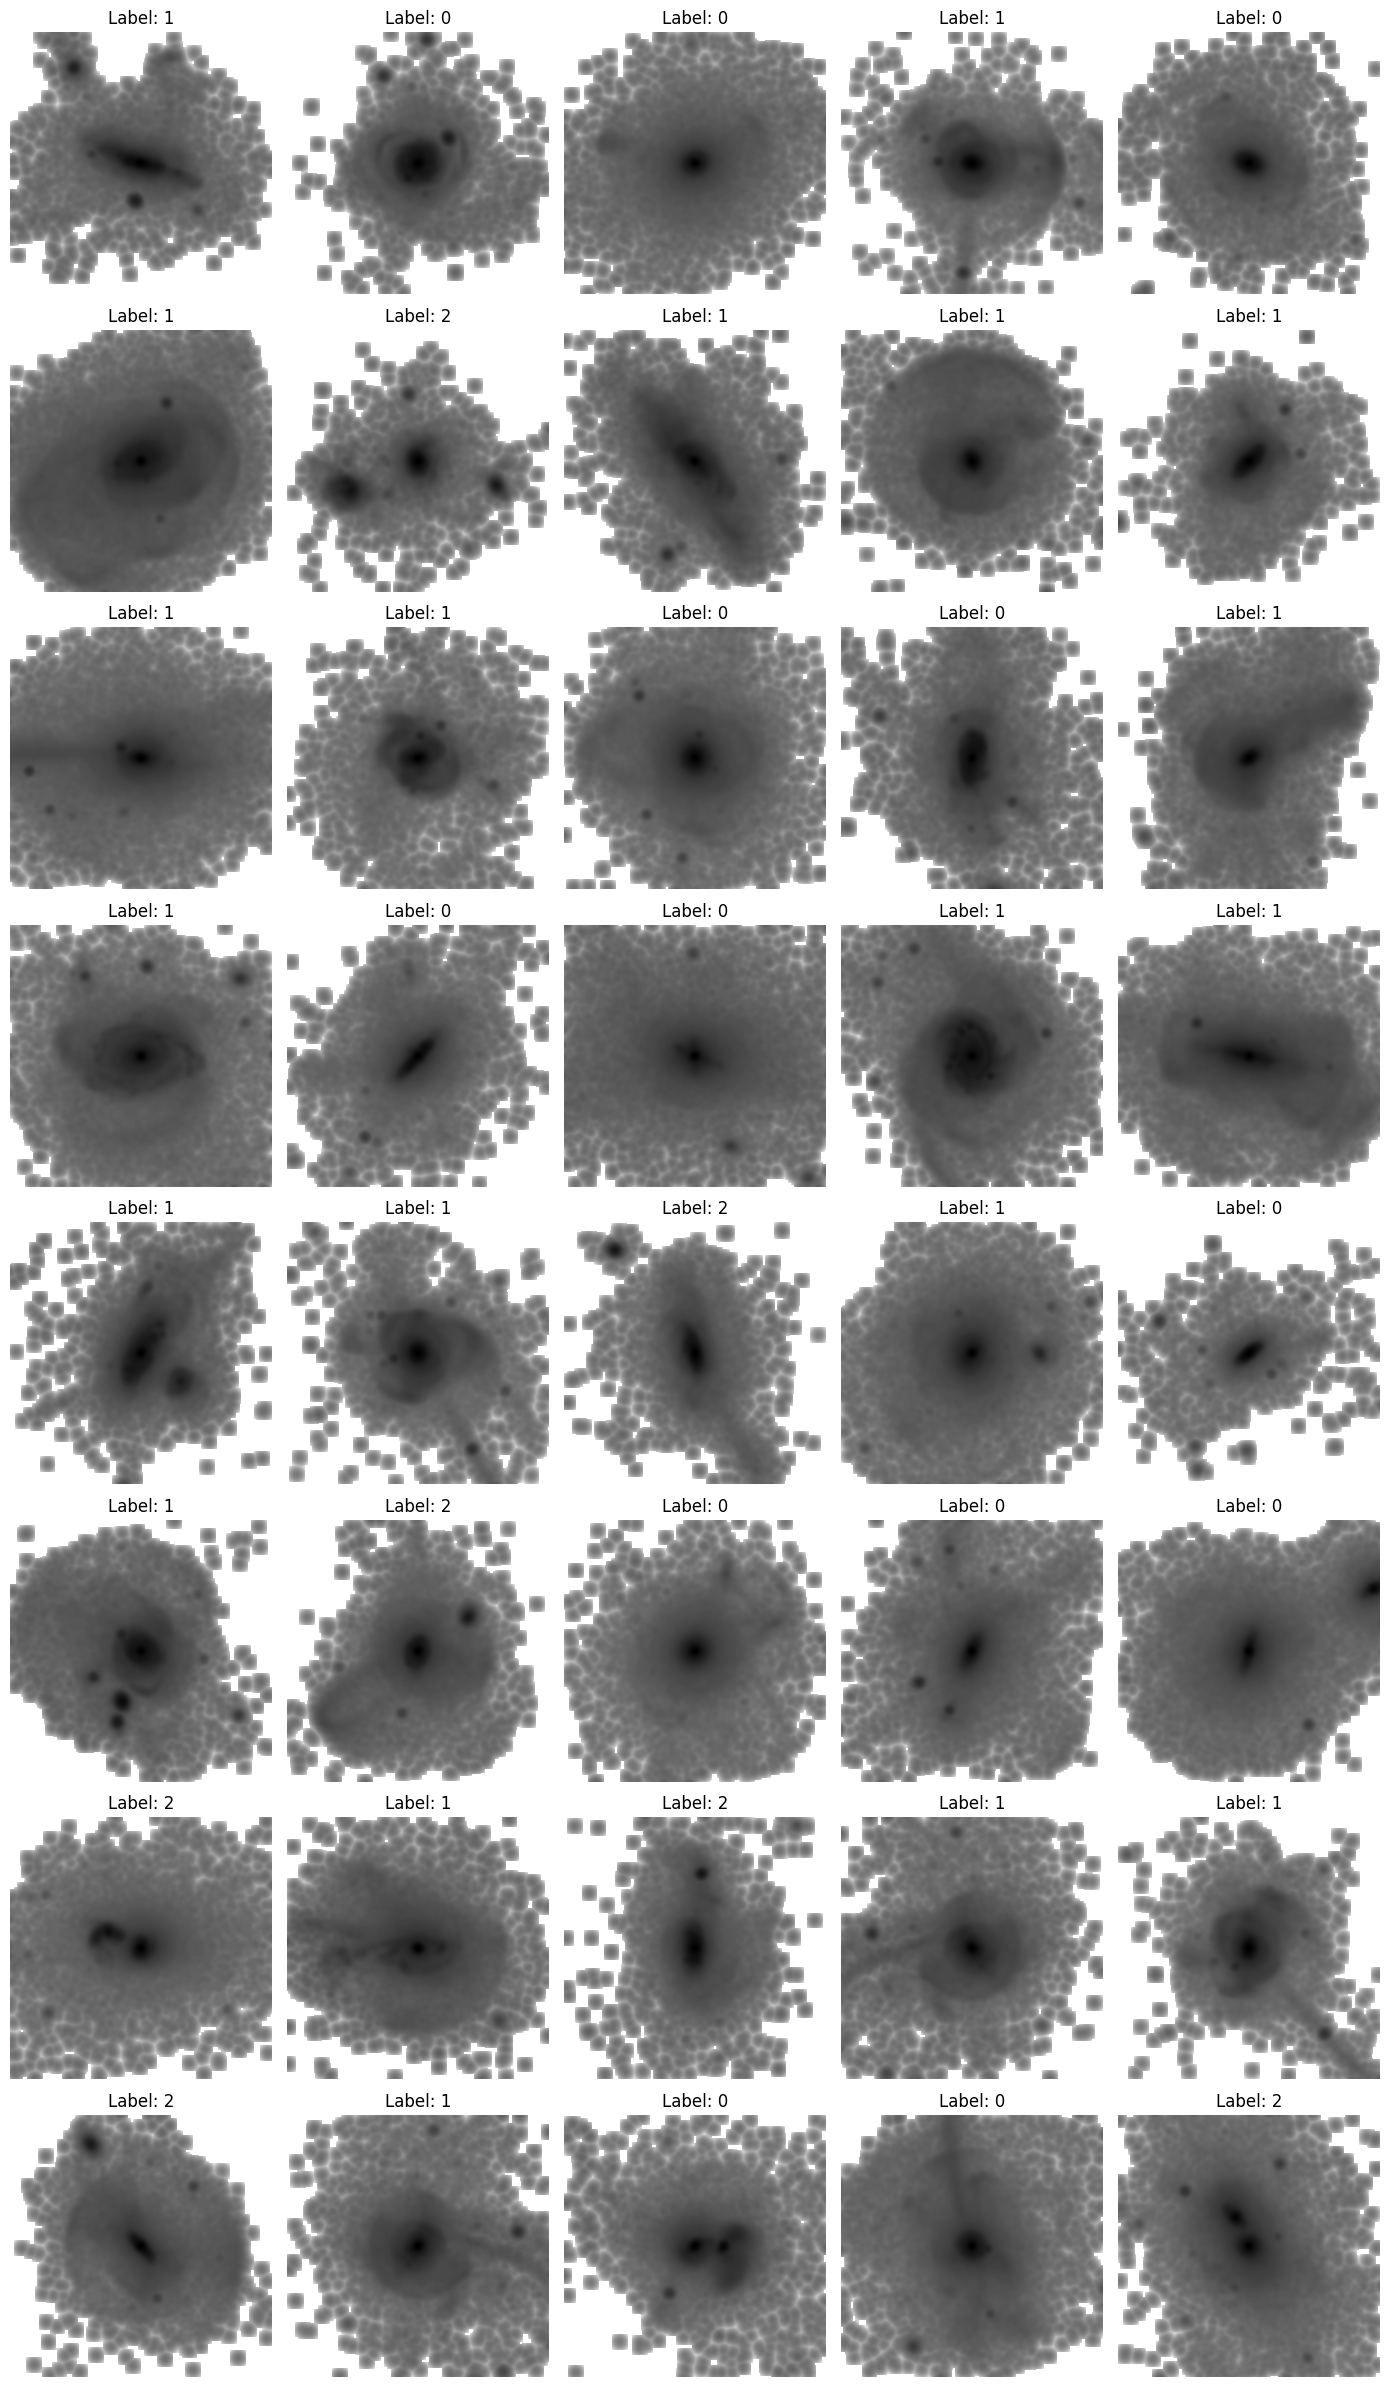

In [46]:
fig=plt.figure(figsize=(14, 24))
for i in range(40):
    ax=plt.subplot(8, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Masking and Normalizing Images 

#### Finding `nan` and `inf` pixels 

In [47]:
print([np.count_nonzero(np.isnan(X_train)), np.count_nonzero(np.isinf(X_train))])

[0, 99529430]


In [48]:
ivalid = ~np.isnan(X_test) & ~np.isinf(X_test)
maxvalue = np.max(X_test[ivalid])
minvalue = np.min(X_test[ivalid])
medvalue = np.median(X_test[ivalid])
lowqvalue = np.percentile(X_test[ivalid],25)
highqvalue = np.percentile(X_test[ivalid],75)
maxvalue = np.ceil(maxvalue)
print([medvalue,lowqvalue,highqvalue,minvalue,maxvalue])

[32.00109373129973, 29.81272271309141, 34.39861269372098, 16.35107886967143, 53.0]


In [49]:
X_test[X_test > medvalue]= medvalue
X_val[X_val > medvalue]= medvalue
X_train[X_train > medvalue]= medvalue

### `masking` < 26

In [9]:
#X_test[X_test<26.0]=0
#X_val[X_val<26.0]=0
#X_train[X_train<26.0]=0

### `Reshaping` and `one-hot encoding`

In [50]:
X_train = X_train.reshape((X_train.shape[0],grids,grids,1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0],grids,grids,1)).astype('float32')
X_val = X_val.reshape((X_val.shape[0],grids,grids,1)).astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
num_classes = y_test.shape[1]

## `Normalization`

In [51]:
maxval = np.max([np.max(X_train[~np.isinf(X_train)]),np.max(X_val[~np.isinf(X_val)]),np.max(X_test[~np.isinf(X_test)])])
minval = np.min([np.min(X_train[~np.isinf(X_train)]),np.min(X_val[~np.isinf(X_val)]),np.min(X_test[~np.isinf(X_test)])])
print(maxval,minval, X_train[~np.isinf(X_train)].max())

32.001095 16.351078 32.001095


#### hong dc's method

In [52]:
X_train = np.abs(1.0 - (X_train - minval) / (maxval - minval))
X_test = np.abs(1.0 - (X_test - minval) / (maxval - minval))
X_val = np.abs(1.0 - (X_val - minval) / (maxval - minval))

X_train = X_train / maxval
X_test = X_test / maxval
X_val = X_val / maxval

### 값이 0 ~ 1 사이로 잘 normalization 되었음을 확인

In [53]:
print(np.max(X_test),np.min(X_test))
print(np.max(X_train),np.min(X_train))
print(np.max(X_val),np.min(X_val))

1.0 0.0
0.9996372 0.0
1.0 0.0


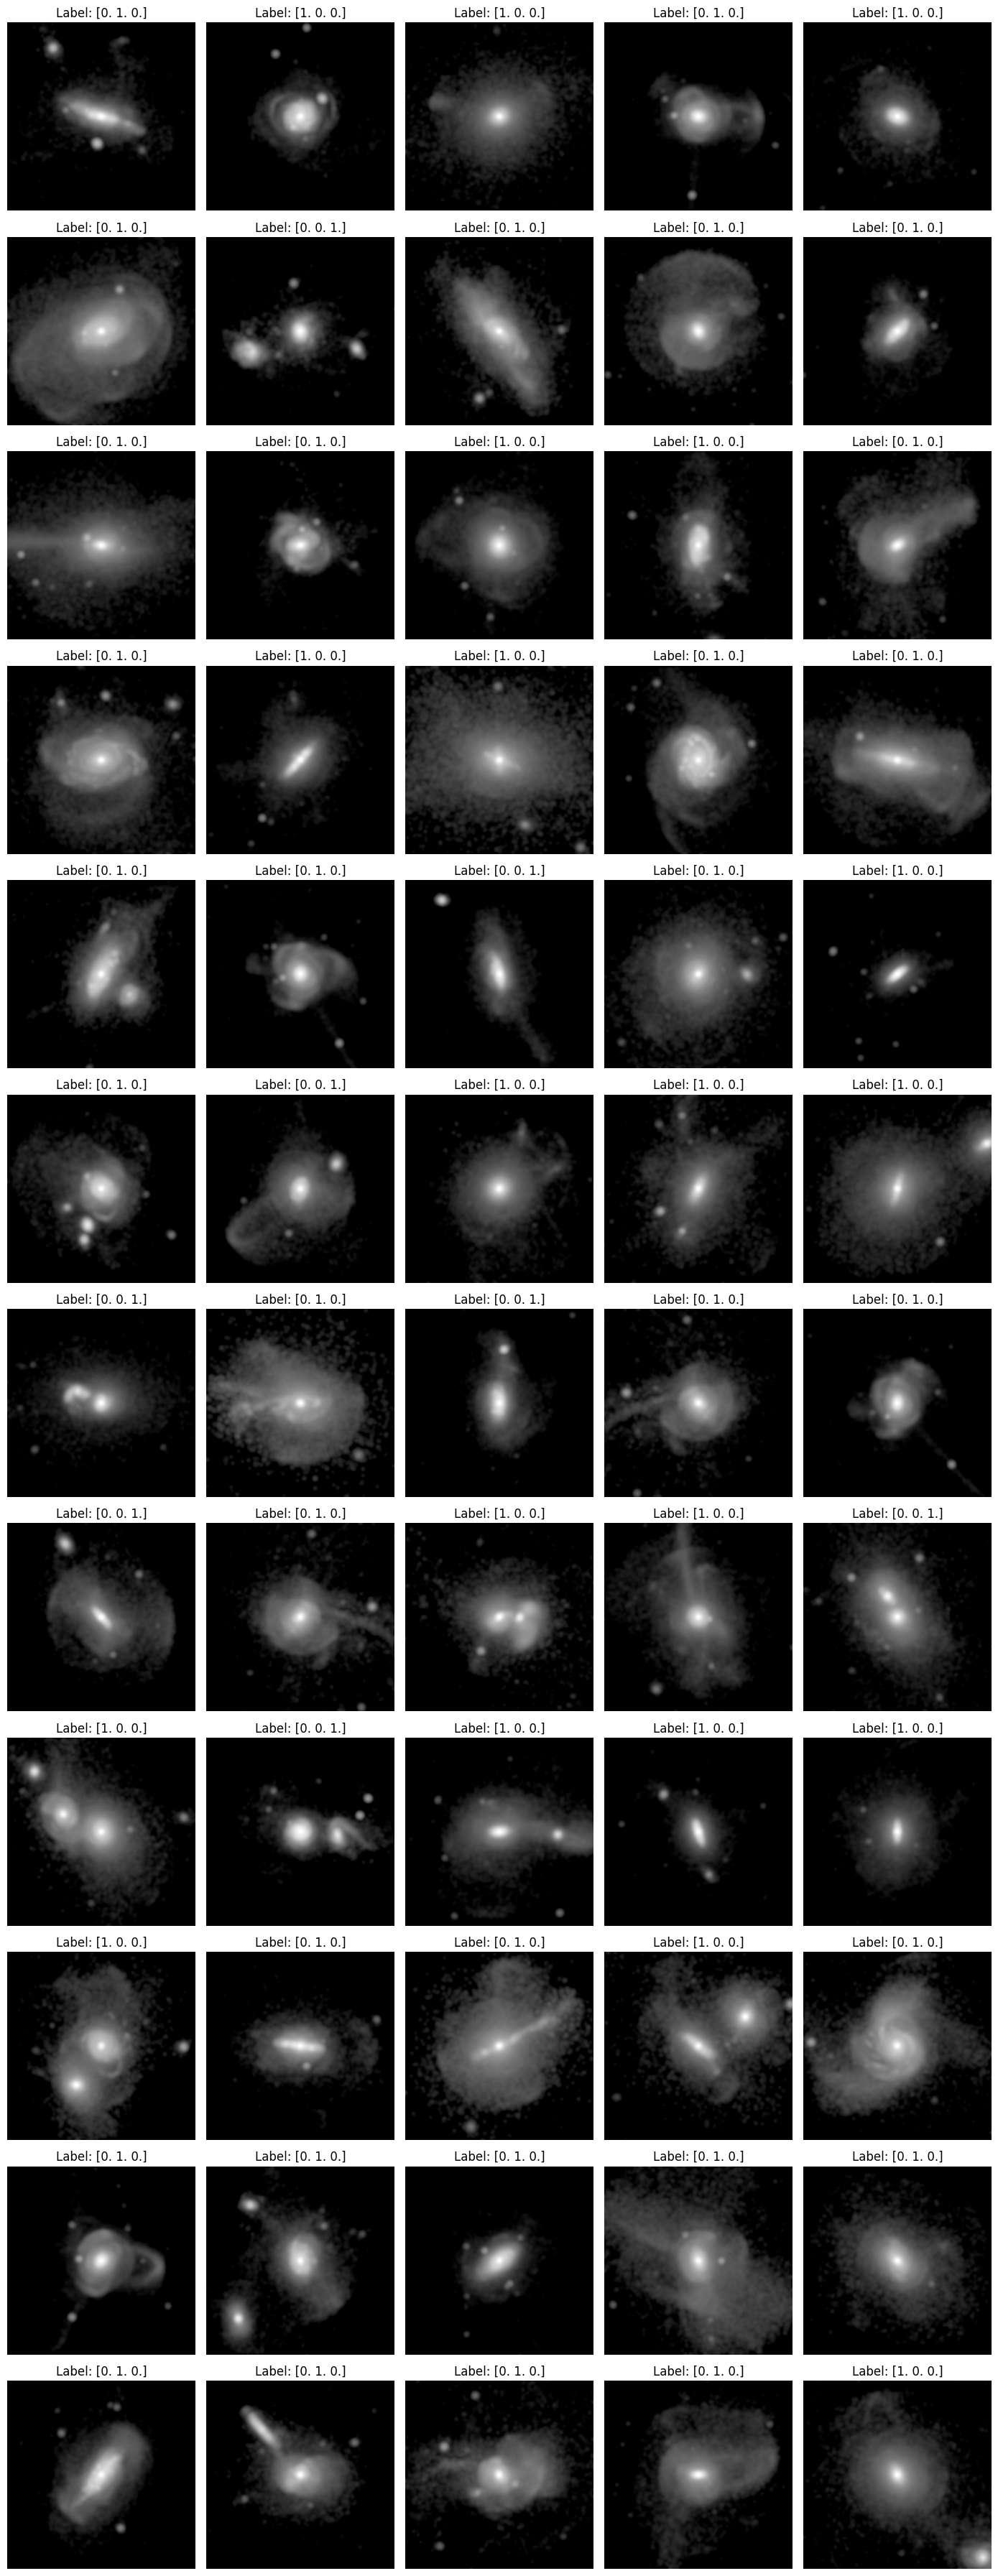

In [54]:
fig=plt.figure(figsize=(14, 36))
for i in range(60):
    ax=plt.subplot(12, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('Label: '+str(y_train[i]))
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# Model building

In [32]:
strategy = tf.distribute.MirroredStrategy()
Droprate=0.2
def baseline_model():
# create model
    model = Sequential()
    model.add(Conv2D(16, (5, 5), input_shape=(grids,grids, 1),strides=(1, 1), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(32, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(32, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(32, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])    
    return model

# build the model
with strategy.scope():
    model=baseline_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-10-05 09:10:35.864473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46686 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [33]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=128, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/200
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-10-05 09:10:45.662990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-05 09:10:47.311657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 09:10:48.994284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 09:10:49.191198: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x224112c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 09:10:49.191238: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-05 09:10:49.198094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] d

17/17 - 28s - loss: 8.6955 - accuracy: 0.4535 - val_loss: 27.5338 - val_accuracy: 0.3676 - 28s/epoch - 2s/step
Epoch 2/200
17/17 - 6s - loss: 0.9248 - accuracy: 0.5470 - val_loss: 43.5916 - val_accuracy: 0.3676 - 6s/epoch - 364ms/step
Epoch 3/200
17/17 - 6s - loss: 0.8422 - accuracy: 0.5428 - val_loss: 47.2026 - val_accuracy: 0.3676 - 6s/epoch - 336ms/step
Epoch 4/200
17/17 - 6s - loss: 0.7675 - accuracy: 0.6404 - val_loss: 46.8521 - val_accuracy: 0.3676 - 6s/epoch - 332ms/step
Epoch 5/200
17/17 - 6s - loss: 0.6852 - accuracy: 0.7067 - val_loss: 45.2002 - val_accuracy: 0.3676 - 6s/epoch - 325ms/step
Epoch 6/200
17/17 - 7s - loss: 0.5977 - accuracy: 0.7564 - val_loss: 42.9732 - val_accuracy: 0.3676 - 7s/epoch - 384ms/step
Epoch 7/200
17/17 - 5s - loss: 0.5493 - accuracy: 0.7790 - val_loss: 39.7281 - val_accuracy: 0.3676 - 5s/epoch - 321ms/step
Epoch 8/200
17/17 - 6s - loss: 0.5003 - accuracy: 0.8020 - val_loss: 35.7304 - val_accuracy: 0.3676 - 6s/epoch - 325ms/step
Epoch 9/200
17/17 - 5

Epoch 67/200
17/17 - 6s - loss: 0.0158 - accuracy: 0.9945 - val_loss: 34.5893 - val_accuracy: 0.3676 - 6s/epoch - 360ms/step
Epoch 68/200
17/17 - 6s - loss: 0.0119 - accuracy: 0.9982 - val_loss: 33.5830 - val_accuracy: 0.3676 - 6s/epoch - 328ms/step
Epoch 69/200
17/17 - 6s - loss: 0.0070 - accuracy: 0.9995 - val_loss: 36.6553 - val_accuracy: 0.3676 - 6s/epoch - 327ms/step
Epoch 70/200
17/17 - 6s - loss: 0.0071 - accuracy: 0.9995 - val_loss: 33.9468 - val_accuracy: 0.3676 - 6s/epoch - 339ms/step
Epoch 71/200
17/17 - 6s - loss: 0.0058 - accuracy: 0.9995 - val_loss: 36.0012 - val_accuracy: 0.3676 - 6s/epoch - 377ms/step
Epoch 72/200
17/17 - 6s - loss: 0.0067 - accuracy: 0.9986 - val_loss: 37.9442 - val_accuracy: 0.3676 - 6s/epoch - 339ms/step
Epoch 73/200
17/17 - 5s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 39.8037 - val_accuracy: 0.3676 - 5s/epoch - 320ms/step
Epoch 74/200
17/17 - 5s - loss: 0.0057 - accuracy: 0.9995 - val_loss: 38.6718 - val_accuracy: 0.3676 - 5s/epoch - 323ms/step


Epoch 133/200
17/17 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 43.7570 - val_accuracy: 0.3676 - 6s/epoch - 335ms/step
Epoch 134/200
17/17 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 44.3899 - val_accuracy: 0.3676 - 6s/epoch - 328ms/step
Epoch 135/200
17/17 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 43.6251 - val_accuracy: 0.3676 - 6s/epoch - 327ms/step
Epoch 136/200
17/17 - 6s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 49.9126 - val_accuracy: 0.3676 - 6s/epoch - 335ms/step
Epoch 137/200
17/17 - 5s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 45.2995 - val_accuracy: 0.3676 - 5s/epoch - 323ms/step
Epoch 138/200
17/17 - 6s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 48.3181 - val_accuracy: 0.3676 - 6s/epoch - 335ms/step
Epoch 139/200
17/17 - 6s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 47.2099 - val_accuracy: 0.3676 - 6s/epoch - 332ms/step
Epoch 140/200
17/17 - 6s - loss: 0.0043 - accuracy: 0.9995 - val_loss: 45.1318 - val_accuracy: 0.3676 - 6s/epoch - 370

17/17 - 6s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 47.2920 - val_accuracy: 0.3676 - 6s/epoch - 361ms/step
Epoch 199/200
17/17 - 6s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 47.9033 - val_accuracy: 0.3676 - 6s/epoch - 365ms/step
Epoch 200/200
17/17 - 6s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 48.7549 - val_accuracy: 0.3676 - 6s/epoch - 324ms/step
Baseline Error: 63.24%


# Confusion Matrix

In [34]:
y_pred=model.predict(X_test)
confM=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))#normalize=True
#per_confM=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),normalize='true')
class_totals = np.sum(confM, axis=1)
cm_norm = confM / class_totals[:, np.newaxis]
#np.savez('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.npz', confusion=confM)

22/22 [==============================] - 1s 17ms/step


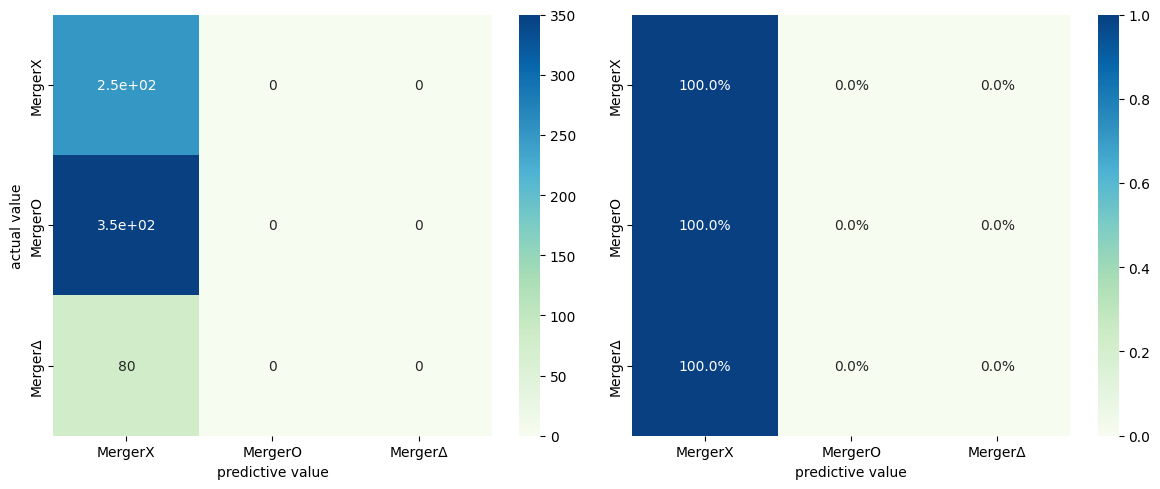

In [35]:
labels=['MergerX','MergerO','MergerΔ']

# Drawing confusion matrix with seaborn
plt.figure(figsize=(12,5))
ax=plt.subplot(1, 2, 1)
sns.heatmap(confM,annot=True,cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
plt.ylabel('actual value')

ax=plt.subplot(1, 2, 2)
sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')

plt.tight_layout()
plt.show()

In [36]:
report=classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),output_dict=True)
df=pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.367647,1.000000,0.537634,250.000000
1,0.000000,0.000000,0.000000,350.000000
2,0.000000,0.000000,0.000000,80.000000
accuracy,0.367647,0.367647,0.367647,0.367647
macro avg,0.122549,0.333333,0.179211,680.000000
weighted avg,0.135164,0.367647,0.197660,680.000000


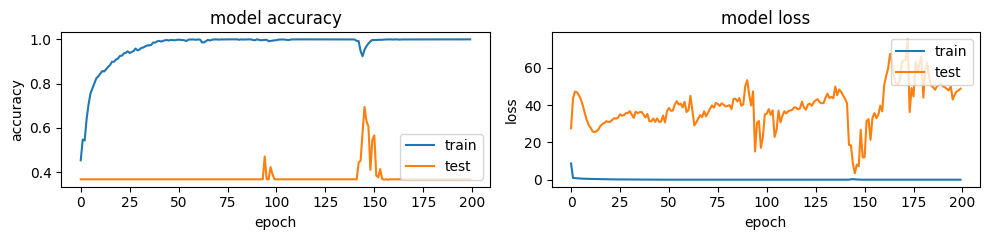

In [37]:
# plotting the metrics
fig = plt.figure(figsize=(10,2.5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()